In [1]:
import numpy as np
from qiskit import QuantumCircuit
from qiskit.circuit.library import StatePreparation
from qiskit.quantum_info import DensityMatrix, state_fidelity
from qclib.state_preparation.util.baa import _split_combinations

from qdna.compression import SchmidtCompressor
from qdna.quantum_info import correlation

In [2]:
n_qubits = 8

In [3]:
from scipy.stats import lognorm
def sample_lognormal_from_moments(n_samples, dim, mean, variance):
    """
    Generate samples from a lognormal distribution given its first four moments.
    
    Parameters:
        n_samples (int): Number of samples.
        dim (int): Dimensionality of the samples.
        mean (float): Desired mean of the lognormal distribution.
        variance (float): Desired variance.
        skewness (float): Desired skewness.
        kurtosis (float): Desired kurtosis.

    Returns:
        np.ndarray: Samples from the lognormal distribution.
    """
    # Compute lognormal parameters
    sigma_sq = np.log(variance / mean**2 + 1)
    sigma = np.sqrt(sigma_sq)
    mu = np.log(mean) - sigma_sq / 2

    # Verify skewness and kurtosis
    computed_skewness = (np.exp(sigma_sq) + 2) * np.sqrt(np.exp(sigma_sq) - 1)
    computed_kurtosis = np.exp(4 * sigma_sq) + 2 * np.exp(3 * sigma_sq) + 3 * np.exp(2 * sigma_sq) - 3

    print(f"Computed Skewness: {computed_skewness}")
    print(f"Computed Kurtosis: {computed_kurtosis}")

    # Sample from lognormal
    samples = lognorm.rvs(sigma, scale=np.exp(mu), size=(n_samples, dim))

    values = samples.flatten()
    x = np.linspace(min(values), max(values), 1000)
    pdf = lognorm.pdf(x, sigma, scale=np.exp(mu))
    
    return samples, pdf, x

In [4]:
from scipy.stats import laplace

def sample_laplace_from_moments(n_samples, dim, mean, variance):
    """
    Generate samples from a Laplace distribution given its first four moments.
    
    Parameters:
        n_samples (int): Number of samples.
        dim (int): Dimensionality of the samples.
        mean (float): Desired mean of the Laplace distribution.
        variance (float): Desired variance.
        skewness (float): Must be 0 for Laplace.
        kurtosis (float): Must be 6 for Laplace.
    
    Returns:
        np.ndarray: Samples from the Laplace distribution.
    """
    # Compute Laplace scale parameter
    b = np.sqrt(variance / 2)
    
    # Sample from Laplace distribution
    samples = laplace.rvs(loc=mean, scale=b, size=(n_samples, dim))
    
    values = samples.flatten()
    x = np.linspace(min(values), max(values), 1000)
    pdf = laplace.pdf(x, loc=mean, scale=b)
    
    return samples, pdf, x

In [6]:
from scipy.stats import norm
def sample_normal_from_moments(n_samples, dim, mean, variance):
    """
    Generate samples from a normal distribution given mean and variance.
    
    Parameters:
        n_samples (int): Number of samples to generate.
        mean (float): Mean of the distribution.
        variance (float): Variance of the distribution.
    
    Returns:
        np.ndarray: Samples drawn from the specified normal distribution.
    """
    std_dev = np.sqrt(variance)
    samples = norm.rvs(loc=mean, scale=std_dev, size=(n_samples, dim))

    values = samples.flatten()
    x = np.linspace(min(values), max(values), 1000)
    pdf = norm.pdf(x, loc=mean, scale=std_dev)

    return samples, pdf, x 

Computed Skewness: 0.8711555544218269
Computed Kurtosis: 4.3791129600000005


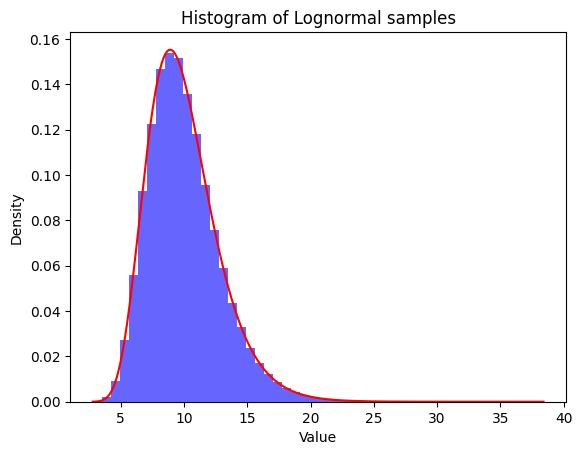

[[0.0733774  0.06495794 0.0970033  ... 0.06481689 0.05119871 0.07290094]
 [0.06392292 0.06108239 0.07080726 ... 0.03435691 0.08164518 0.04494888]
 [0.07413706 0.06388256 0.04597934 ... 0.07108597 0.0347791  0.04023213]
 ...
 [0.04892952 0.05934236 0.04229076 ... 0.03794451 0.08199253 0.05487919]
 [0.04495173 0.03680219 0.02928252 ... 0.05835073 0.09123982 0.05168608]
 [0.06172285 0.05079538 0.06130899 ... 0.07414862 0.06456677 0.06183865]]


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def sample_watson_distribution(n_samples: int, dim: int = 16, distribution: str = "laplace"):
    """
    Generate samples from a Watson-like distribution where all coordinates are positive.
    Supports multiple probability distributions.

    Parameters:
        n_samples (int): Number of samples to generate.
        dim (int): Dimensionality of the samples (default: 16).
        distribution (str): Choice of distribution ('laplace', 'lognormal', 'normal').

    Returns:
        np.ndarray: An array of shape (n_samples, dim) with unit-norm samples, all positive.
    """
    mean = 20.0
    variance = 8.0
    if distribution == "laplace":
        # mean = 10.0
        # variance = 8.0
        samples, pdf, x = sample_laplace_from_moments(n_samples, dim, mean, variance)

    elif distribution == "lognormal":
        mean = 10.0 # 3.297 # 2.0
        variance = 8.0 # 18.68 # 1.5
        samples, pdf, x = sample_lognormal_from_moments(n_samples, dim, mean, variance)

    elif distribution == "normal":
        # mean = 10.0
        # variance = 8.0
        samples, pdf, x = sample_normal_from_moments(n_samples, dim, mean, variance)

    else:
        raise ValueError("Unsupported distribution. Choose from 'normal', 'laplace', 'lognormal'.")

    # Normalize each sample to unit norm
    positive_watson_samples = samples / np.linalg.norm(samples, axis=1, keepdims=True)

    return positive_watson_samples, samples, pdf, x

# Example usage
n_samples = 1000  # Generate 1000 samples
distribution_choice = "lognormal"  # Change this to 'normal', 'laplace', or 'lognormal'
data, raw_samples, pdf, x = sample_watson_distribution(n_samples, dim=2**n_qubits, distribution=distribution_choice)

# Flatten the data to plot a histogram of individual coordinates
plt.hist(raw_samples.flatten(), bins=50, density=True, alpha=0.6, color='b')
plt.plot(x, pdf, 'r-', label='Theoretical PDF')
plt.title(f"Histogram of {distribution_choice.capitalize()} samples")
plt.xlabel("Value")
plt.ylabel("Density")
# plt.grid()
plt.show()

print(data)


In [8]:
# Dataset load.
seed = 42

np.random.seed(seed=42)
training_input, raw_training, _, _ = sample_watson_distribution(n_samples=n_samples, dim=2**n_qubits, distribution=distribution_choice)
test_input, raw_test, _, _ = sample_watson_distribution(n_samples=n_samples, dim=2**n_qubits, distribution=distribution_choice)

feature_dim = len(training_input[0])

# Variables to collect data for the summary.
fidelities = [[],[],[]]

Computed Skewness: 0.8711555544218269
Computed Kurtosis: 4.3791129600000005
Computed Skewness: 0.8711555544218269
Computed Kurtosis: 4.3791129600000005


***
## Experiment main routine
***

In [ ]:
# Creates an example of the circuit.
def complete_circuit(state_vector, compressor, decompressor):

    # Typical state initializer.
    initializer = StatePreparation(state_vector)

    # Creates the quantum circuit.
    circuit = QuantumCircuit(n_qubits)

    # Circuit on Alice's side.
    circuit.append(initializer.definition, range(n_qubits))
    circuit.append(compressor.definition, range(n_qubits))
    circuit.reset(compressor.trash_qubits)

    # Circuit on Bob's side.
    circuit.append(decompressor.definition, range(n_qubits))

    return circuit    

def experiment(test_input, compressor, decompressor, verbose=1):
    # Applies the compression-decompression process to each of the test samples.

    fidelities = []

    # Iterates through all test samples.
    for i, test_sample in enumerate(test_input):
        circuit = complete_circuit(test_sample, compressor, decompressor)

        # Compares the recovered state with the original state.
        input_state = DensityMatrix(test_sample, dims=2**n_qubits)
        output_state = DensityMatrix(circuit)

        fidelity = state_fidelity(input_state, output_state)

        # Stores and prints the results.
        fidelities.append(fidelity)
        if verbose > 0:
            print(i, '-', fidelity)
        
    return fidelities

***
## Calculates the typical state
***

In [10]:
# Estimate the centroid.
# Simply the average of the training samples (or a random selection of samples).

centroid = np.zeros(2**n_qubits)
for train_sample in training_input:
    centroid += train_sample

typical_state = centroid / np.linalg.norm(centroid)

print(typical_state.shape)

(256,)


***
## Find the best partitioning configuration.
***

In [12]:
# Defines the number of latent qubits.
# `0 < n_latent_qubits < n_qubits`.
n_latent_partition = n_qubits // 2

n_trash_partition = n_qubits - n_latent_partition

min_entropy = np.iinfo(np.int32).max # 2147483648
for partition in _split_combinations(range(n_qubits), n_latent_partition):
    set_a = set(partition)
    set_b = set(range(n_qubits)).difference(set_a)
    entropy = correlation(typical_state, set_a, set_b)

    print('latent', set_a, 'trash', set_b, 'entropy', entropy)

    if entropy <= min_entropy:
        min_entropy = entropy
        latent_partition = sorted(partition)
        trash_partition = sorted(set(range(n_qubits)).difference(set(latent_partition)))

latent {0, 1, 2, 3} trash {4, 5, 6, 7} entropy 0.002546447514140475
latent {0, 1, 2, 4} trash {3, 5, 6, 7} entropy 0.002628042394884459
latent {0, 1, 2, 5} trash {3, 4, 6, 7} entropy 0.0026164108424639237
latent {0, 1, 2, 6} trash {3, 4, 5, 7} entropy 0.0026034952008455923
latent {0, 1, 2, 7} trash {3, 4, 5, 6} entropy 0.002547531111908364
latent {0, 1, 3, 4} trash {2, 5, 6, 7} entropy 0.002666296781478614
latent {0, 1, 3, 5} trash {2, 4, 6, 7} entropy 0.002653569601362038
latent {0, 1, 3, 6} trash {2, 4, 5, 7} entropy 0.002643070408830876
latent {0, 1, 3, 7} trash {2, 4, 5, 6} entropy 0.0025890684530998015
latent {0, 1, 4, 5} trash {2, 3, 6, 7} entropy 0.0026680911590264826
latent {0, 1, 4, 6} trash {2, 3, 5, 7} entropy 0.00250272100718278
latent {0, 1, 4, 7} trash {2, 3, 5, 6} entropy 0.0025705189595181402
latent {0, 1, 5, 6} trash {2, 3, 4, 7} entropy 0.00260908312586942
latent {0, 1, 5, 7} trash {2, 3, 4, 6} entropy 0.002631952467328932
latent {0, 1, 6, 7} trash {2, 3, 4, 5} entrop

In [13]:
print('Best channel:', latent_partition)

Best channel: [0, 2, 3, 5]


***
## Creates the compressor and the decompressor
***

In [14]:
# Creates the compressor.
compressor = SchmidtCompressor(typical_state, opt_params={'partition': trash_partition, 'lr': 0})
decompressor = compressor.inverse()

***
## Experiment
***
Using |0> as the reference state.


### Draw an example of the circuit


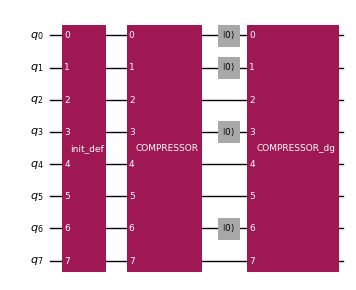

In [15]:
circuit = complete_circuit(typical_state, compressor, decompressor)
# Draw the circuit diagram.
circuit.draw('mpl', scale=0.5, style="iqp")

### Run the experiment without optimization

In [16]:
fidelities[0] = experiment(
    test_input,
    compressor,
    decompressor,
    verbose=0
)

***
## Summary
***

In [ ]:
zip_fidelities = list(zip(fidelities[0]))

print('distribution:', distribution_choice)
print('avg', *np.average(zip_fidelities, axis=0))
print('min', *np.min(zip_fidelities, axis=0))
print('max', *np.max(zip_fidelities, axis=0))
print('std', *np.std(zip_fidelities, axis=0))

distribution: lognormal
avg 0.8698625455459872
min 0.8235463627540548
max 0.9066545074390935
std 0.012224777304522283
